In [22]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

%matplotlib widget 


In [23]:
import env

Environment closely follows OpenAI gym API. Currently can not be invoked with ```gym.make("env_id")```, though it should be easy to do.

In [24]:
checkers_env = env.Env()

A state is ```(5+NUMBER_OF_PIECES, BOARD_SIZE, BOARD_SIZE) ndarray```

Where

* ```state[0]``` — black pieces
* ```state[1]``` — white pieces
* ```state[2]``` — pieces ids
* ```state[3]``` — current turn (blacks=1, whites=0)
* ```state[4]``` — whether game in terminal state
* ```state[5+i]``` — allowed moves for piece number i

I should probably move allowed moves elsewhere but I have a lot of RAM to keep things unoptimized.


In [25]:

def show_state(state):
    plt.imshow(state)
    plt.show()

def show_board(board):
   cmap = colors.ListedColormap(['white', 'red'])
   bounds=[0,0.5,18]
   norm = colors.BoundaryNorm(bounds, cmap.N)
   # plt.figure(figsize=(4,4))
   plt.imshow(board, cmap=cmap, norm=norm, interpolation='none')
   plt.xticks(np.arange(0.5,8.5), [])
   plt.yticks(np.arange(0.5,8.5), [])

   plt.grid()

Plots above: 

1. Piece number 2
2. Possible moves for piece number 2

In [26]:
import monte_carlo_tree


def random_play():
    '''
    Play a game using random tree strategy
    '''
        
    tree = monte_carlo_tree.RandomPlayTree(checkers_env, 8)
    
    root_node = tree.root_node
    terminal_node, reward = tree.simulate(root_node)
    
    return terminal_node, reward
    

def build_random_play_stats(n_games=1):
    '''
    Play a number of random games and display result
    '''

    black_wins = 0
    white_wins = 0
    draws = 0
    moves = []
    
    for _ in range(n_games):
        m, reward = random_play()
        if reward > 0:
            black_wins += 1
        elif reward < 0:
            white_wins += 1
        elif reward == 0:
            draws += 1
       
        moves.append(m)
    
    print("Blacks: ", black_wins, "Whites: ", white_wins, "Draws: ", draws, "Moves mean:", np.mean(moves))

In [27]:
import time
np.random.seed(seed=int(time.time())) 

# terminal_node, reward = random_play()

In [28]:
# trajectory = terminal_node.unroll()

In [29]:
def do_the_flip(arr):
    return arr
    return np.flip(np.flip(np.flip(arr, 0), 0), 1)

def show_trajectory_item(trajectory, index):
    board_i = monte_carlo_tree.state_to_board(trajectory[index].original_state)
    show_board(do_the_flip(board_i[0] + board_i[1]))

In [30]:
# show_trajectory_item(trajectory[::-1], 0)

In [31]:
tree = monte_carlo_tree.RandomPlayTree(checkers_env, 8)

final_node, reward = tree.simulate(tree.root_node)

0
1
2
3
4
5
6
7
8
9


In [32]:
trajectory = list(final_node.unroll()[::-1])

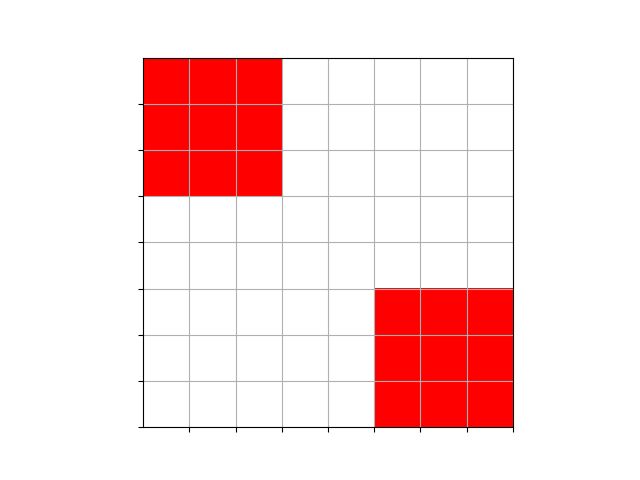

In [33]:
%matplotlib widget 

def state_to_board(state):
    return np.flip(state[0] + state[1], 0)

def move_delta(trajectory, index):
    current = trajectory[index]
    previous = trajectory[index-1]

    return current- previous

state = trajectory[-1].state

show_board(np.flip(state[0] + state[1], 0))

In [34]:
print(trajectory[1].move)
print(trajectory[1].original_state['turn']['color'])
print(trajectory[1].original_state['pieces'])
print(trajectory[1].original_state['moveset'][8])

(2, 5, 1, 4)
White
[{'color': 'White', 'y': 5, 'x': 0, 'id': 0}, {'color': 'White', 'y': 6, 'x': 0, 'id': 1}, {'color': 'White', 'y': 7, 'x': 0, 'id': 2}, {'color': 'White', 'y': 5, 'x': 1, 'id': 3}, {'color': 'White', 'y': 6, 'x': 1, 'id': 4}, {'color': 'White', 'y': 7, 'x': 1, 'id': 5}, {'color': 'White', 'y': 5, 'x': 2, 'id': 6}, {'color': 'White', 'y': 6, 'x': 2, 'id': 7}, {'color': 'White', 'y': 7, 'x': 2, 'id': 8}, {'color': 'Black', 'y': 0, 'x': 5, 'id': 9}, {'color': 'Black', 'y': 1, 'x': 5, 'id': 10}, {'color': 'Black', 'y': 2, 'x': 5, 'id': 11}, {'color': 'Black', 'y': 0, 'x': 6, 'id': 12}, {'color': 'Black', 'y': 1, 'x': 6, 'id': 13}, {'color': 'Black', 'y': 2, 'x': 6, 'id': 14}, {'color': 'Black', 'y': 0, 'x': 7, 'id': 15}, {'color': 'Black', 'y': 1, 'x': 7, 'id': 16}, {'color': 'Black', 'y': 2, 'x': 7, 'id': 17}]
[[3, 6], [3, 7]]
